In [1]:
# %pip install statsmodels
# %pip install folium

# 1. Motivation.

* *What is your dataset?*
* *Why did you choose this/these particular dataset(s)?*
* *What was your goal for the end user's experience?*

We have chosen a dataset about Melbourne [1]. It contains two main topics: 
1. Pedestrians counting devices with locations and hourly counts 
2. Microclimate sensors with their measurement times, locations and measuring different weather data like temperature, relative humidity, mass density of particles (smaller than 2.5 and 10 micrometers) in the air and wind speed

This is a great dataset to demonstrate the effect of weather on people and through that, bring the reader a bit closer to the confusing and abstract topic climate change. If people start realizing, that climate change is already happening and it affects everyone including them, we hope they will start to actually do something against it.


Who is this article for? These questions might help you make that decision:
* Have you ever wondered about what factors influence that how many people are on the streets? 
* Can climate change affect that? 
* Do you hate crowds or just want to take a nice a picture for your instagram without random people's photobomb? 
* Or the exact opposite, do you want to meet new people? 

If your answer is yes to at least one question, than the following article is for you!

# 2. Basic stats, let's understand the dataset better

* One does not simply feed multiple millions of rows of data to an AI, thus we needed to preprocess our table first. In this section you can read about our way of thinking and our methods of improving the quality of our data.

In [51]:
# imports and settings
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from plotly import express as px
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from bokeh.io import output_notebook, curdoc
from bokeh.plotting import figure, show,output_file, save
import bokeh
import matplotlib.pyplot as plt
from bokeh.layouts import layout
from bokeh.io import show, output_notebook, reset_output, curdoc, output_file
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import ColumnDataSource, Legend, HoverTool
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import brewer, Spectral, Viridis3, Viridis256, d3
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, BasicTicker, ColorBar, LinearColorMapper
from bokeh.transform import cumsum, factor_cmap, transform, jitter

import folium
from folium import plugins
from folium.plugins import HeatMap

pd.set_option("display.max_columns", None)

In [52]:
# read in everything the four files

micro_sens_locations = pd.read_csv("Microclimate_Sensor_Locations.csv")
micro_sens_values = pd.read_csv("Microclimate_Sensor_Readings.csv")
ped_counter_locations = pd.read_csv("Pedestrian_Counting_System_-_Sensor_Locations.csv")
ped_count_values = pd.read_csv("Pedestrian_Counting_System_-_Monthly__counts_per_hour_.csv")


ped_count_values['Date_Time'] =  pd.to_datetime(ped_count_values['Date_Time'], format = '%B %d, %Y %I:%M:%S %p')
micro_sens_values['local_time'] =  pd.to_datetime(micro_sens_values['local_time'], format = '%Y/%m/%d %I:%M:%S %p')

# Filtering for years
micro_sens_values = micro_sens_values[(micro_sens_values['local_time'].dt.date>= datetime.date(2019,1,1))]  
ped_count_values = ped_count_values[(ped_count_values['Date_Time'].dt.date>= datetime.date(2019,1,1))]  

# A. Clustering

To see what we are working with, we created a couple of visualizations first. Thanks to that, we were able to see that the locations of the sensors can be divided into five rather distinct areas. There are some outliers and there some that don't immediately reveal which area they belong to. So we have called for the help of K-means clustering.

Since there were fever microclimate sensors, we chose those to base our clusters on. After that, we determined the sizes of the clusters and mapped the pedestrians sensors to the clusters. We have omitted the ones that fell outside the clusters. You can see the results on the maps below.

Below the map with the sensors locations, you can find an animated heatmap, that shows the amount of pedestrians over each month, starting with year 2019.

In [53]:
x = micro_sens_locations.iloc[:,7:9] # latitude and longitude

kmeans = KMeans(5)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)

micro_sens_locations['cluster'] = identified_clusters

In [54]:
# centers of the clusters
# calculation is not 100% correct because of the polar coordinates, 
# but we are letting it slip because no time and not affect final result a lot
cluster_centers = micro_sens_locations.groupby('cluster').agg({"longitude": np.mean, "latitude": [np.mean]})
cluster_centers.columns = cluster_centers.columns.get_level_values(0)
cluster_centers = cluster_centers.reset_index()
cluster_centers[['longitude','latitude']].to_records(index = False)

# Earth diameter = 40000000 meters
# 360 degrees
def coordinate_distance_to_meter(coordinate_distance):
    return coordinate_distance * (40000000/360)
    
def meter_to_coordinate_distance(meter):
    return meter / (40000000/360)

# the closest points, to determine the size of the circles
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis = 1)
    return np.argmin(dist_2)

# the size of the circle has to be the half of the distance
def circle_size(node, closest):
    return coordinate_distance_to_meter(np.sqrt((node[0] - closest[0])**2 + (node[1] - closest[1])**2)) / 2

sizes = []
for idx, row in cluster_centers.iterrows():
    point = row[['longitude','latitude']].to_numpy()
    other_points = list(cluster_centers[cluster_centers['cluster'] !=  idx][['longitude','latitude']].to_numpy())
    closest = closest_node(point, other_points)
    size = circle_size(other_points[closest], point)
    sizes.append(size)

cluster_centers["size"] = sizes

In [55]:
def which_cluster_contains(cluster_centers, location):
    for idx, row in cluster_centers.iterrows():
        asd = meter_to_coordinate_distance(row["size"])
        if np.sqrt((row["latitude"] - location["latitude"])**2 + (row["longitude"] - location["longitude"])**2) < asd:
            return idx
    return -1

clusters = []
for idx, row in ped_counter_locations.iterrows():
    clusters.append(which_cluster_contains(cluster_centers,row))
ped_counter_locations["cluster"] = clusters

ped_counter_locations = ped_counter_locations.drop(ped_counter_locations[ped_counter_locations['cluster'] ==  -1].index)

In [56]:
# Melbourne
base_lat = -37.8136
base_lon = 144.9631

MEL = folium.Map([base_lat, base_lon], tiles = "Stamen Toner", zoom_start = 14)

points = list(micro_sens_locations.loc[:, ["latitude", "longitude"]].to_records(index = False))

colors = ['darkred', 'darkblue', 'darkgreen', 'black', 'darkpurple']
colors2 = ['red', 'blue', 'green', 'gray', 'purple']

for idx, row in micro_sens_locations.iterrows():
    folium.Marker(
        location = [row["latitude"],row["longitude"]],
        popup = row["description"],
        icon = folium.Icon(color = colors[row['cluster']], icon = "info-sign"),
    ).add_to(MEL)

for idx, row in ped_counter_locations.iterrows():
    folium.Marker(
        location = [row["latitude"],row["longitude"]],
        popup = row["sensor_description"],
        icon = folium.Icon(color = colors2[row['cluster']], icon = "info-sign"),
    ).add_to(MEL)

for idx, row in cluster_centers.iterrows():
    folium.Circle(
        radius = row["size"],
        location = [row["latitude"],row["longitude"]],
        color = "crimson",
        fill = False,
    ).add_to(MEL)

MEL

In [57]:
# this way we can order each year by months
ped_count_values["Month_num"] = ped_count_values["Date_Time"].apply(lambda x: x.month)
ped_count_values_sums = ped_count_values.groupby(["Year", "Month_num", "Sensor_ID"]).agg({"Hourly_Counts": [np.sum, np.mean]})

In [58]:
MEL = folium.Map([base_lat, base_lon], tiles = "Stamen Toner", zoom_start = 14)

# Monthly visitors in area

heat_data_2 = []
for yearly, yearly_df in ped_count_values_sums.groupby(level = 0):
    for monthly, monthly_df in yearly_df.groupby(level = 1):
        rows = []
        for indices, hourly_counts in monthly_df.iterrows():
            try:
                monthly_sum = hourly_counts[0]
                sensor_id = indices[2]
                indexof_location = ped_counter_locations[ped_counter_locations["sensor_id"] == sensor_id]["latitude"].first_valid_index() 
                sensor_latitude = ped_counter_locations[ped_counter_locations["sensor_id"] == sensor_id]["latitude"][indexof_location]
                sensor_longitude = ped_counter_locations[ped_counter_locations["sensor_id"] == sensor_id]["longitude"][indexof_location]
                rows.append([sensor_latitude, sensor_longitude, monthly_sum])
            except:
                pass
                # print(indices)
        heat_data_2.append(rows)

for idx, row in cluster_centers.iterrows():
    folium.Circle(
        radius = row["size"],
        location = [row["latitude"],row["longitude"]],
        color = "crimson",
        fill = False,
    ).add_to(MEL)


# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_2, auto_play = True, max_opacity = 0.8)
hm.add_to(MEL)

# Display the map
MEL

# B. Sensor data processing

To be able to feed the data to ML algorithms, we needed to process the measurements of the sensors. Our computers were not necessarily the best fit for data processing, so we decided to output the processed data to a csv file, and free up memory.

Below you can find an the average steps pedestrians took in each location after 2019. Thanks to this we know which sites were to most popular and which were the least crowded ones. This can give us a hint on what to expect when predicting for the number of pedestrians. We can see that the top performer was a temporary sensor. Checking the name and comparing it to others, we can see that the sensors are generally located in tram stops. Based on these findings we can already see which areas are the most crowded, so the city might want to increase or decrease the amount of trams going on these lines.

In [59]:
# get weather informations
weather = micro_sens_locations.merge(micro_sens_values, on = ['site_id', 'gateway_hub_id'])

In [60]:
# manipulate columns so we can execute a join operation on the tables

ped_count_values = ped_count_values.drop(columns = ["ID"])
ped_counter_locations = ped_counter_locations.drop(columns = ["sensor_name", "note", "installation_date", "status"])

In [61]:
# do the actual join

ped_counters = pd.merge(ped_counter_locations, ped_count_values, left_on = "sensor_id", right_on = "Sensor_ID")
ped_counters = ped_counters.set_index(["sensor_id", "Year"])


In [62]:
# Download the dataframe
# ped_counters.to_csv('pedest.csv')

# Download the dataframe
# weather.to_csv('weather.csv')

In [63]:
weather = pd.read_csv('weather.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [64]:
pedest = pd.read_csv('pedest.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## C. Some basic stats

In [65]:
# Get only rows with useful information

weather_new = weather[weather['type'].isin(['WS', 'TPH.TEMP-EPA-1h', 'TPH.RH-EPA-1h', 'PM2.5-EPA-1h', 'PM10-EPA-1h'])].reset_index()
weather_new = weather_new.drop(columns = ['Unnamed: 0', 'description', 'start_reading', 'end_reading', 'index'])

<AxesSubplot:xlabel='site_id'>

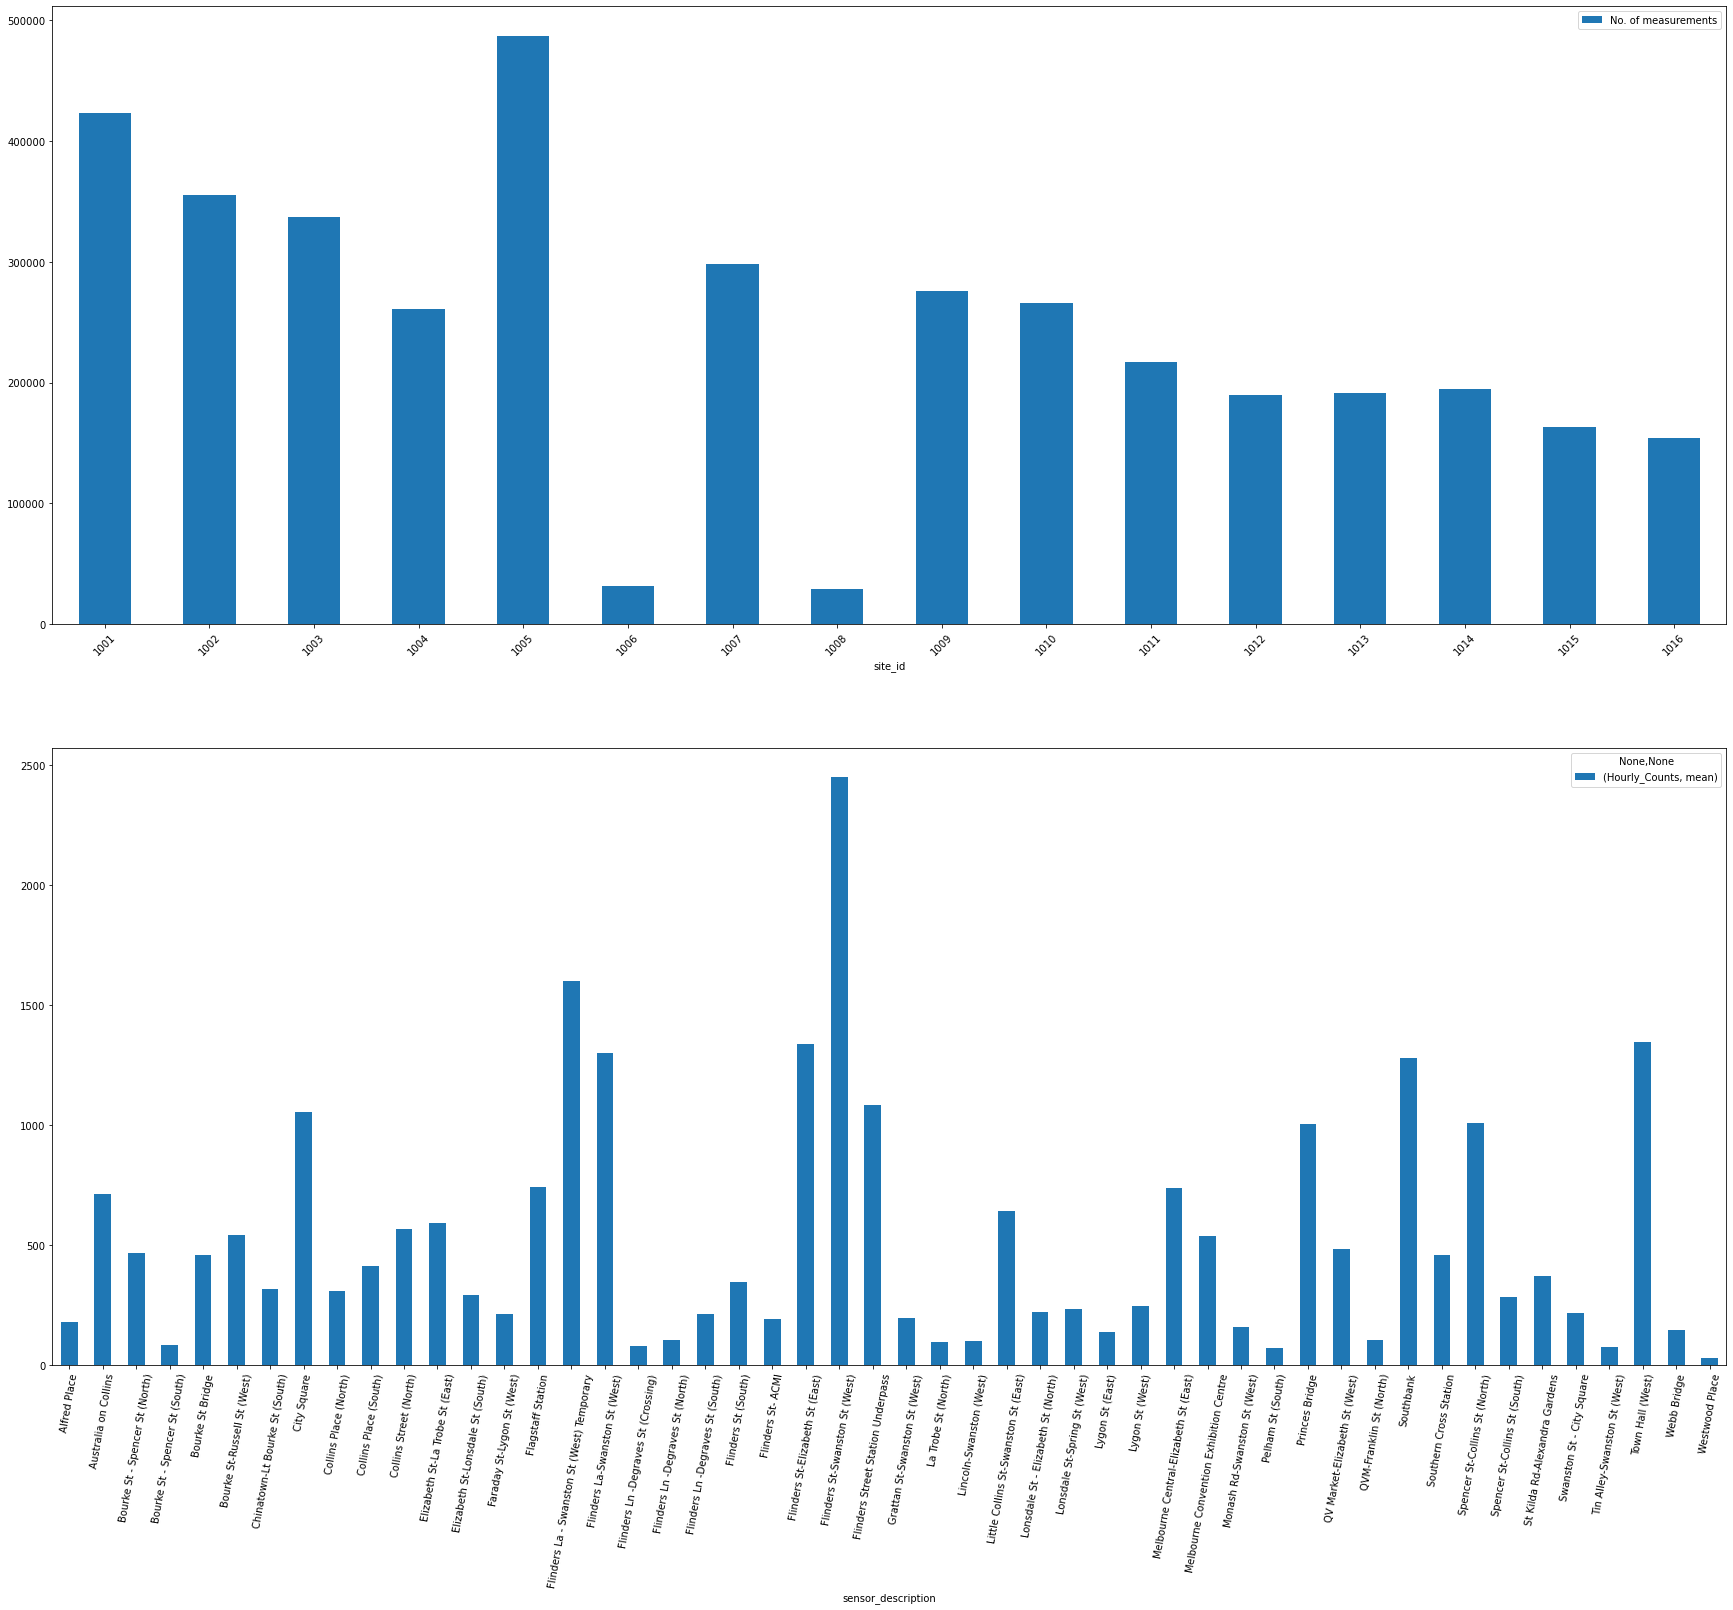

In [8]:
basics1 = pedest.groupby(["sensor_description"]).agg({"Hourly_Counts": [np.mean]})
basics1=basics1.reset_index()
basics2 = weather.groupby(["site_id"]).agg({"value": "count"})
basics2 = basics2.reset_index()
basics2 = basics2.rename(columns = {"value": "No. of measurements"})

fig, ax = plt.subplots(2, 1, figsize=(30,25))
basics1.plot.bar(x='sensor_description', rot=80, ax=ax[1])
basics2.plot.bar(x='site_id', rot=45, ax=ax[0])
#fig.savefig('basics.jpg')

The first plot above shows the number of measurements at each site and the second the mean hourly counts of pedestrians at each locations. We can see that the place at Flinders St - Swantson St (West).

# 3. Analysis and ML

This section has 3 subsections, as we chose multiple approaches to analyze the data. 

* First, you can read about some more statistics
* Second, you can read about how we prepared the data for machine learning
* And third, you can read about different ML algorithms and their output

## A. Seasonality analysis

We would like to see wether there is some kind of pattern in a year for both the weather parameters and the number of pedestrians. Below you can find a plot with of the **wind speed**, **temperate** and **relative humidity**. Based on this we find that these three have a little correlation, especially **temperature** and **relative humidity**. This finding is not surprising, and **relative humidity** is based on the **temperature**. **Winds** are rather consistent throughout the year in Melbourne. The city being located by a seashore this is not surprising.

In [66]:
# Get a datetime column
weather_new['datetime'] =  pd.to_datetime(weather_new.local_time)

In [67]:
# Add columns with year, month, and weekday name
weather_new['Year'] = weather_new.datetime.apply(lambda x: x.year)
weather_new['Month'] = weather_new.datetime.apply(lambda x: x.month)
weather_new['Weekday Name'] = weather_new.datetime.apply(lambda x: x.day_name())

In [68]:
# Get different dataframes for each types
wind = weather_new[weather_new['type'].isin(['WS'])].reset_index()
del wind['index']
wind = wind.set_index('datetime')
temperature = weather_new[weather_new['type'].isin(['TPH.TEMP-EPA-1h'])].reset_index()
del temperature['index']
temperature = temperature.set_index('datetime')
relhumidity = weather_new[weather_new['type'].isin(['TPH.RH-EPA-1h'])].reset_index()
del relhumidity['index']
relhumidity = relhumidity.set_index('datetime')
psize25 = weather_new[weather_new['type'].isin(['PM2.5-EPA-1h'])].reset_index()
del psize25['index']
psize25 = psize25.set_index('datetime')
psize10 = weather_new[weather_new['type'].isin(['PM10-EPA-1h'])].reset_index()
del psize10['index']
psize10 = psize10.set_index('datetime')

In [13]:
from bokeh.plotting import figure, show

# find the quartiles and IQR for each category
groups = wind.sort_values('Month').groupby('Month')
q1 = groups.quantile(q = 0.25)
q2 = groups.quantile(q = 0.5)
q3 = groups.quantile(q = 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group.value > upper.loc[cat]['value']) | (group.value < lower.loc[cat]['value'])]['value']
out = groups.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = list(out.index.get_level_values(0))
    outy = list(out.values)


# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups.quantile(q = 0.00)
qmax = groups.quantile(q = 1.00)
upper.value = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'value']),upper.value)]
lower.value = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'value']),lower.value)]

# separate ColumnDataSource for boxes
boxes_data = pd.concat([q1.rename(columns = {"value":"q1"}),
                        q2.rename(columns = {"value":"q2"}),
                        q3.rename(columns = {"value":"q3"}),
                        iqr.rename(columns = {"value":"iqr"}),
                        lower.rename(columns = {"value":"lower"}),
                        upper.rename(columns = {"value":"upper"})
                        ], axis = 1)

figwind = figure(tools = "", background_fill_color = "#efefef",toolbar_location = None, plot_width = 1000, plot_height = 700)

# boxes
#figwind.vbar(cats, 0.7, q2.value, q3.value, fill_color = "#E08E79", line_color = "black")
#figwind.vbar(cats, 0.7, q1.value, q2.value, fill_color = "#3B8686", line_color = "black")

boxes_source = ColumnDataSource(boxes_data)
top_box = figwind.vbar("Month", 0.7, "q2", "q3", fill_color = "#E08E79", line_color = "black", source = boxes_source)
bottom_box = figwind.vbar("Month", 0.7, "q1", "q2", fill_color = "#3B8686",line_color = "black", source = boxes_source)

# whiskers (almost-0 height rects simpler than segments)
figwind.rect("Month", "lower", 0.2, 0.01, line_color = "black",  source = boxes_source)
figwind.rect("Month", "upper", 0.2, 0.01, line_color = "black",  source = boxes_source)

# stems
figwind.segment("Month", "upper", "Month", "q3", line_color = "black", source = boxes_source)
figwind.segment("Month", "lower", "Month", "q1", line_color = "black", source = boxes_source)

# outliers
#if not out.empty:
    #p.circle(outx, outy, size = 6, color = "#F38630", fill_alpha = 0.6)

figwind.xgrid.grid_line_color = None
figwind.ygrid.grid_line_color = "white"
figwind.grid.grid_line_width = 2
figwind.xaxis.major_label_text_font_size = "16px"

# add hover just to the two box renderers
box_hover = HoverTool(renderers = [top_box, bottom_box],
                         tooltips = [
                             ('q1', '@q1'),
                             ('q2', '@q2'),
                             ('q3', '@q3'),
                             ('iqr', '@iqr')
                         ])

figwind.add_tools(box_hover)

#show(figwind)

# Source: https://docs.bokeh.org/en/latest/docs/gallery/boxplot.html

In [14]:
# find the quartiles and IQR for each category
groups2 = temperature.sort_values('Month').groupby('Month')
q1 = groups2.quantile(q = 0.25)
q2 = groups2.quantile(q = 0.5)
q3 = groups2.quantile(q = 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group.value > upper.loc[cat]['value']) | (group.value < lower.loc[cat]['value'])]['value']
out = groups2.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = list(out.index.get_level_values(0))
    outy = list(out.values)

figtemperature = figure(tools = "", background_fill_color = "#efefef", toolbar_location = None, plot_width = 900, plot_height = 700)

# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups2.quantile(q = 0.00)
qmax = groups2.quantile(q = 1.00)
upper.value = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'value']),upper.value)]
lower.value = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'value']),lower.value)]

# separate ColumnDataSource for boxes
boxes_data2 = pd.concat([q1.rename(columns = {"value":"q1"}),
                        q2.rename(columns = {"value":"q2"}),
                        q3.rename(columns = {"value":"q3"}),
                        iqr.rename(columns = {"value":"iqr"}),
                        lower.rename(columns = {"value":"lower"}),
                        upper.rename(columns = {"value":"upper"})
                        ], axis = 1)

figtemperature = figure(tools = "", background_fill_color = "#efefef",toolbar_location = None, plot_width = 900, plot_height = 700)

#boxes
boxes_source2 = ColumnDataSource(boxes_data2)
top_box2 = figtemperature.vbar("Month", 0.7, "q2", "q3", fill_color = "#E08E79", line_color = "black", source = boxes_source2)
bottom_box2 = figtemperature.vbar("Month", 0.7, "q1", "q2", fill_color = "#3B8686",line_color = "black", source = boxes_source2)

# whiskers (almost-0 height rects simpler than segments)
figtemperature.rect("Month", "lower", 0.2, 0.01, line_color = "black",  source = boxes_source2)
figtemperature.rect("Month", "upper", 0.2, 0.01, line_color = "black",  source = boxes_source2)

# stems
figtemperature.segment("Month", "upper", "Month", "q3", line_color = "black", source = boxes_source2)
figtemperature.segment("Month", "lower", "Month", "q1", line_color = "black", source = boxes_source2)

# outliers
#if not out.empty:
    #p.circle(outx, outy, size = 6, color = "#F38630", fill_alpha = 0.6)

figtemperature.xgrid.grid_line_color = None
figtemperature.ygrid.grid_line_color = "white"
figtemperature.grid.grid_line_width = 2
figtemperature.xaxis.major_label_text_font_size = "16px"

# add hover just to the two box renderers
box_hover2 = HoverTool(renderers = [top_box2, bottom_box2],
                         tooltips = [
                             ('q1', '@q1'),
                             ('q2', '@q2'),
                             ('q3', '@q3'),
                             ('iqr', '@iqr')
                         ])

figtemperature.add_tools(box_hover2)

In [15]:
# find the quartiles and IQR for each category
groups3 = relhumidity.sort_values('Month').groupby('Month')
q1 = groups3.quantile(q = 0.25)
q2 = groups3.quantile(q = 0.5)
q3 = groups3.quantile(q = 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr

cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# find the outliers for each category
def outliers(group):
    cat = group.name
    return group[(group.value > upper.loc[cat]['value']) | (group.value < lower.loc[cat]['value'])]['value']
out = groups3.apply(outliers).dropna()

# prepare outlier data for plotting, we need coordinates for every outlier.
if not out.empty:
    outx = list(out.index.get_level_values(0))
    outy = list(out.values)

# separate ColumnDataSource for boxes
boxes_data3 = pd.concat([q1.rename(columns = {"value":"q1"}),
                        q2.rename(columns = {"value":"q2"}),
                        q3.rename(columns = {"value":"q3"}),
                        iqr.rename(columns = {"value":"iqr"}),
                        lower.rename(columns = {"value":"lower"}),
                        upper.rename(columns = {"value":"upper"})
                        ], axis = 1)    
    
figrelhumidity = figure(tools = "", background_fill_color = "#efefef", toolbar_location = None, plot_width = 900, plot_height = 700)

# if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
qmin = groups3.quantile(q = 0.00)
qmax = groups3.quantile(q = 1.00)
upper.value = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'value']),upper.value)]
lower.value = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'value']),lower.value)]

#boxes
boxes_source3 = ColumnDataSource(boxes_data3)
top_box3 = figrelhumidity.vbar("Month", 0.7, "q2", "q3", fill_color = "#E08E79", line_color = "black", source = boxes_source3)
bottom_box3 = figrelhumidity.vbar("Month", 0.7, "q1", "q2", fill_color = "#3B8686",line_color = "black", source = boxes_source3)

# whiskers (almost-0 height rects simpler than segments)
figrelhumidity.rect("Month", "lower", 0.2, 0.01, line_color = "black",  source = boxes_source3)
figrelhumidity.rect("Month", "upper", 0.2, 0.01, line_color = "black",  source = boxes_source3)

# stems
figrelhumidity.segment("Month", "upper", "Month", "q3", line_color = "black", source = boxes_source3)
figrelhumidity.segment("Month", "lower", "Month", "q1", line_color = "black", source = boxes_source3)

# outliers
#if not out.empty:
    #p.circle(outx, outy, size = 6, color = "#F38630", fill_alpha = 0.6)

figrelhumidity.xgrid.grid_line_color = None
figrelhumidity.ygrid.grid_line_color = "white"
figrelhumidity.grid.grid_line_width = 2
figrelhumidity.xaxis.major_label_text_font_size = "16px"

# add hover just to the two box renderers
box_hover3 = HoverTool(renderers = [top_box3, bottom_box3],
                         tooltips = [
                             ('q1', '@q1'),
                             ('q2', '@q2'),
                             ('q3', '@q3'),
                             ('iqr', '@iqr')
                         ])

figrelhumidity.add_tools(box_hover3)

In [16]:
#Adding the three plots together!
reset_output()
output_notebook()

text = """Figure 1. Wind speed's, Temperature's and Relative Humidity's  Minimum, Maximum, Median and First and Third Quartiles for Each Month.
"""
figwind.add_layout(bokeh.models.Title(text = text, align = "left"), "below")
figtemperature.add_layout(bokeh.models.Title(text = text, align = "left"), "below")
figrelhumidity.add_layout(bokeh.models.Title(text = text, align = "left"), "below")


l1 = layout([[figwind]])
l2 = layout([[figtemperature]])
l3 = layout([[figrelhumidity]])


tab1 = Panel(child = l1,title = "Wind")
tab2 = Panel(child = l2,title = "Temperature")
tab3 = Panel(child = l3,title = "Relative Humidity")
tabs = Tabs(tabs = [tab1, tab2, tab3])
#curdoc().add_root(tabs)

show(tabs)

Loading BokehJS ...

Since the high load of information, it is useful to resample our time series data to a lower frequency. It involves an aggregation operation, in our case, computing monthly and weakly pedestrians counts from the dataset.

The resample() method is used, which splits the DatetimeIndex into time bins and groups the data by time bin. The resample() method returns a Resampler object, similar to a pandas GroupBy object. We will apply an aggregation method such as mean() to the data group for each time bin.

In [70]:
# Get datetime column
pedest['datetime'] =  pd.to_datetime(pedest['Date_Time'], infer_datetime_format = True)

In [71]:
# Organize data by date
pedest = pedest.sort_values('datetime', ascending = True)
pedest = pedest.set_index('datetime')

# Resample to weekly frequency, aggregating with mean
resampled_weekly = pedest['Hourly_Counts'].resample('W').mean()
resampled_weekly = resampled_weekly.reset_index()
resampled_weekly = resampled_weekly.set_index('datetime')

# Resample to monthly frequency, aggregating with mean
resampled_monthly = pedest['Hourly_Counts'].resample('M').mean()
resampled_monthly = resampled_monthly.reset_index()
resampled_monthly = resampled_monthly.set_index('datetime')

In [19]:
def plot_resampled():    
    # Start and end of the date range to extract
    start, end = '2019-01', '2019-12'
    # Plot monthly and weekly resampled time series together
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, ax = plt.subplots()
    ax.plot(resampled_monthly.loc[start:end, 'Hourly_Counts'], marker = '.', linestyle = '-', linewidth = 0.5, label = 'Monthly Mean Resample')
    ax.plot(resampled_weekly.loc[start:end, 'Hourly_Counts'], marker = 'o', markersize = 8, linestyle = '-', label = 'Weekly Mean Resample')
    ax.set_ylabel('Number of Pedestrians')
    ax.legend();

The following plot shows the resampled data only in 2019 (because this year was not influenced by the pandemic so we can focus on only the weather). After resampling and averaging the **number of pedestrians**, we can observe a little correlation with the **temperature**. Taking a deeper look, we can see that jumps happen during the periods where people generally tend to have freetime, so we can assume that they choose to have their breaks from work when the weather is good. The monthly mean time series is smoother than the weekly time series. If we look at the monthly resampled line, we can observe a bit of connection with the temperature. As we start from January (the warmest month), the number of pedestrians in a month starts growing and peaking in April and May. From that, it starts decreasing, as the weather gets colder, and has the lowest point in the coldest month. 

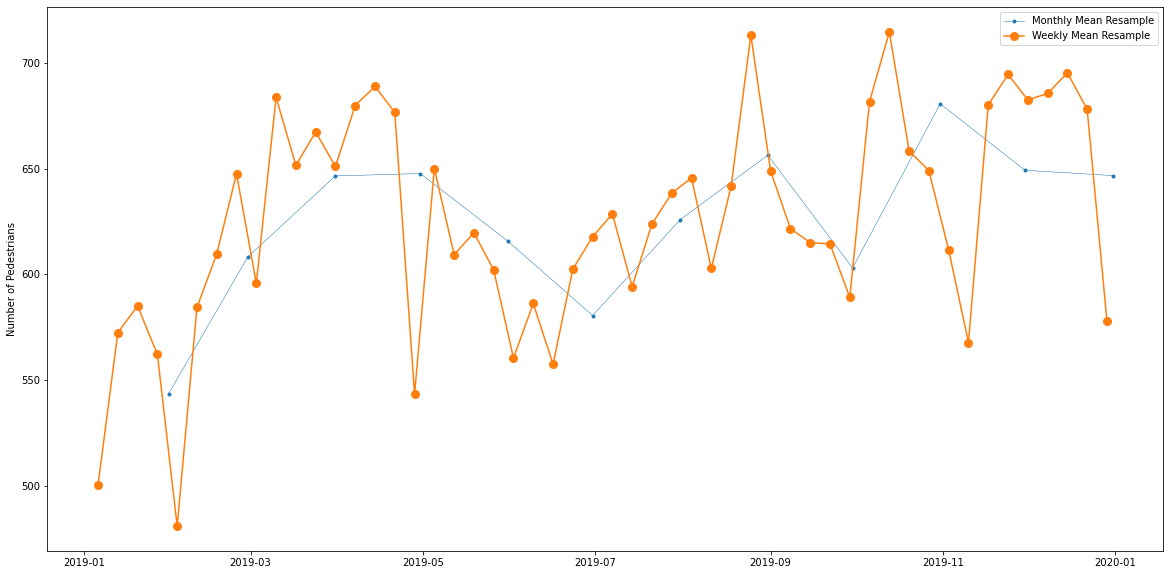

In [20]:
plot_resampled()

## B. Preparing dataframe for ML

Machine learning algorithms are very sensitive for the input data. If the data is not in a proper format, the output is going to be garbage. After separating the different microclimate sensors, we have re-merged them into one big DataFrame, that provided us the basis of our machine learning. First, we made a correlation analysis, the results of which you can find below. We saw that the fields that correlate most with the **number of pedestrians** are **temperature** and **relative humidity**. 

Unfortunately not all sensors were available for multiple years, for example the pedestrian counters only provided us data for a couple of months, so we can not find any correlation between the **month** and the **number of pedestrians**.

In [72]:
# Dataframes for merging

# Get wind value column
grp_wind = wind.copy().reset_index()

grp_wind = grp_wind[['datetime', 'cluster', 'value']]
grp_wind = grp_wind.rename(columns = {"value": "wind_speed"})
grp_wind['datetime'] = grp_wind['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

grp_wind = grp_wind.groupby(["cluster", "datetime"]).agg({"wind_speed": np.mean}).fillna(0)["wind_speed"]
grp_wind = grp_wind.reset_index()

# Get temperature value column
grp_temperature = temperature.copy().reset_index()

grp_temperature = grp_temperature[['datetime', 'cluster', 'value']]
grp_temperature = grp_temperature.rename(columns = {"value": "temperature"})
grp_temperature['datetime'] = grp_temperature['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

grp_temperature = grp_temperature.groupby(["cluster", "datetime"]).agg({"temperature": np.mean}).fillna(0)["temperature"]
grp_temperature = grp_temperature.reset_index()

# Get wind rel. humidity column
grp_relhumidity = relhumidity.copy().reset_index()

grp_relhumidity = grp_relhumidity[['datetime', 'cluster', 'value']]
grp_relhumidity = grp_relhumidity.rename(columns = {"value": "relhumidity"})
grp_relhumidity['datetime'] = grp_relhumidity['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

grp_relhumidity = grp_relhumidity.groupby(["cluster", "datetime"]).agg({"relhumidity": np.mean}).fillna(0)["relhumidity"]
grp_relhumidity = grp_relhumidity.reset_index()

# Get particular size 10 value column
grp_psize10 = psize10.copy().reset_index()

grp_psize10 = grp_psize10[['datetime', 'cluster', 'value']]
grp_psize10 = grp_psize10.rename(columns = {"value": "psize10"})
grp_psize10['datetime'] = grp_psize10['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

grp_psize10 = grp_psize10.groupby(["cluster", "datetime"]).agg({"psize10": np.mean}).fillna(0)["psize10"]
grp_psize10 = grp_psize10.reset_index()

# Get particular size 2.5 value column
grp_psize25 = psize25.copy().reset_index()

grp_psize25 = grp_psize25[['datetime', 'cluster', 'value']]
grp_psize25 = grp_psize25.rename(columns = {"value": "psize25"})
grp_psize25['datetime'] = grp_psize25['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

grp_psize25 = grp_psize25.groupby(["cluster", "datetime"]).agg({"psize25": np.mean}).fillna(0)["psize25"]
grp_psize25 = grp_psize25.reset_index()

# Get pedestrian dataframe
pedestrians = pedest.copy().reset_index()

pedestrians = pedestrians[['datetime', 'cluster', 'Hourly_Counts']]
pedestrians['datetime'] = pedestrians['datetime'].apply(lambda x: x.round('60min').to_pydatetime())

pedestrians = pedestrians.groupby(["cluster", "datetime"]).agg({"Hourly_Counts": np.mean}).fillna(0)["Hourly_Counts"]
pedestrians = pedestrians.reset_index()

In [73]:
# THE MERGE
merge1 = pd.merge(grp_wind, grp_temperature, on = ['datetime', 'cluster'])
merge2 = pd.merge(merge1, grp_relhumidity, on = ['datetime', 'cluster'])
merge3 = pd.merge(merge2, grp_psize10, on = ['datetime', 'cluster'])
merge4 = pd.merge(merge3, grp_psize25, on = ['datetime', 'cluster'])
themerge = pd.merge(merge4, pedestrians, on = ['datetime', 'cluster'])

In [22]:
# Download the dataframe
# themerge.to_csv('themerge.csv')
themerge = pd.read_csv("themerge.csv")
# Get a datetime column
themerge['datetime'] =  pd.to_datetime(themerge.datetime)
del themerge['Unnamed: 0']

In [23]:
# Add columns with year, month, and weekday name
themerge['Year'] = themerge.datetime.apply(lambda x: x.year)
themerge['Month'] = themerge.datetime.apply(lambda x: x.month)
themerge['Weekday'] = themerge.datetime.apply(lambda x: x.dayofweek)

In [24]:
themerge.columns

Index(['cluster', 'datetime', 'wind_speed', 'temperature', 'relhumidity',
       'psize10', 'psize25', 'Hourly_Counts', 'Year', 'Month', 'Weekday'],
      dtype='object')

In [38]:
df = themerge.copy()
corrmat = df.corr()

corrmat.index.name = 'AllColumns1'
corrmat.columns.name = 'AllColumns2'

# Prepare data.frame in the right format
corrmat = corrmat.stack().rename("value").reset_index()

reset_output()
output_notebook()

# I am using 'Viridis256' to map colors with value, change it with 'colors' if you need some specific colors
mapper = LinearColorMapper(
    palette=Viridis256, low=corrmat.value.min(), high=corrmat.value.max())

# Define a figure and tools
TOOLS = "box_select,lasso_select,pan,wheel_zoom,box_zoom,reset,help, hover"
pcorr = figure(
    tools=TOOLS,
    tooltips="@value",
    plot_width=900,
    plot_height=700,
    title="Correlation plot",
    x_range=list(corrmat.AllColumns1.drop_duplicates()),
    y_range=list(corrmat.AllColumns2.drop_duplicates()),
    toolbar_location="right",
    x_axis_location="below")

# Create rectangle for heatmap
pcorr.rect(
    x="AllColumns1",
    y="AllColumns2",
    width=1,
    height=1,
    source=ColumnDataSource(corrmat),
    line_color=None,
    fill_color=transform('value', mapper))

# Add legend
color_bar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    ticker=BasicTicker(desired_num_ticks=10))

pcorr.xaxis.major_label_orientation = "vertical"

pcorr.add_layout(color_bar, 'right')

#output_file('corrmat.html')

show(pcorr)

Loading BokehJS ...

The correlation matrix aboce shows the correlations among numberical features. The cluster (location) has a small correlation with the wind speed, probably because more open places tend to be windier than others. It also correlates a bit with the hourly counts, which we have seen in the beginning, that there are more popular places than others. Furthermore, there seem to be a stronger connection between cluster and year. Year also correlates with the hourly counts. The data is between the years 2019 and 2022, when a word pandemic happened with temporarly lockdowns which can be a cause behind this pattern. The relative humidity depends on the temperature therefore, they have a strong positive correlation. The particular sizes do not show correlation with any other feature. However, the hourly counts also correlate with the temperature (which is no surprise, who wants to go out in cold weather anyway?). It was also suspected based on the diagram with the monthly and weekly resampled data.

## C. Machine learning

### i. Predicting the number of pedestrians

There are a number of uses we can find for future predictions of the number of pedestrians. For example the temperatures are in extremely high values, and we want to hand out water bottles for the passerbys, we want to plan roadworks accordingly, transport a person of high security safely without having to lock down multiple roads or having to increase the number of trams passing by for a period. These are all cases predictions would be useful. For prediction, we have decided on multiple approaches:
* Regression
* Random Forest
* Regression with binning
* Random Forest with binning

<u>**Regression:**</u> We trained a linear regression model on our data. Below you can find the output of the predicted and observed values. With an error of 36.08%, we decided to try another approach as well.

<u>**Random Forest:**</u> Taking a look at a random forest, we can see that we have much better results. With an error of 73.54% we are confident that this could be put to a real world use, to predict the number of people in an area.

After this we tried binning the pedestrian counts along the hundred values. We decided on this, that a binning maybe a better approach that trying to predict the exact number, because less values could mean an easier decision, thus resulting in higher accuracy.

<u>**Regression with binning:**</u> Linear regression resulted in an error of 48.84%, so we have improved slightly.

<u>**Random Forest with binning:**</u> Moving to the random forest, we saw that binning has worsened our results to 72.41%.

The overall conclusion is that binning does not help in our case for predictions, but as we are seeing good results, we would recommend using a system like this in the named cases.

In [39]:
# Preparation for ML

# Get dummies
model = themerge.drop(columns = ['datetime', 'Year'])
model = pd.get_dummies(model, columns = ['cluster'], drop_first = False)

# Split the data into train/test set
from sklearn.model_selection import train_test_split

y = model['Hourly_Counts']
x = model[:]
del x['Hourly_Counts']

rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = rs)

#standardize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

R^2 for Linear Regression: 0.360752


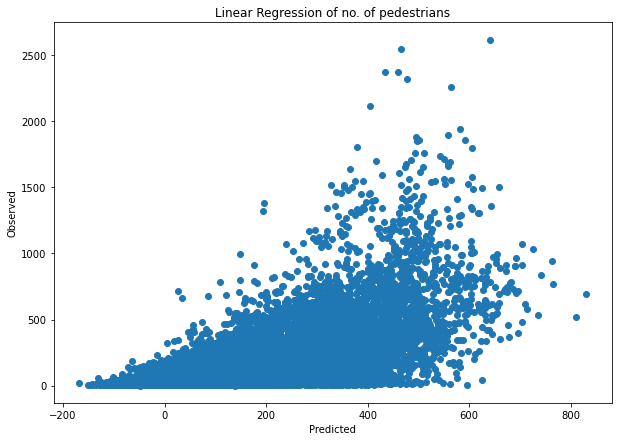

In [40]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

print("R^2 for Linear Regression: %f" % lr.score(x_test, y_test))
    
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_lr, y_test)
plt.title("Linear Regression of no. of pedestrians")
plt.xlabel("Predicted")
plt.ylabel("Observed");

R^2 for Random Forest: 0.738365


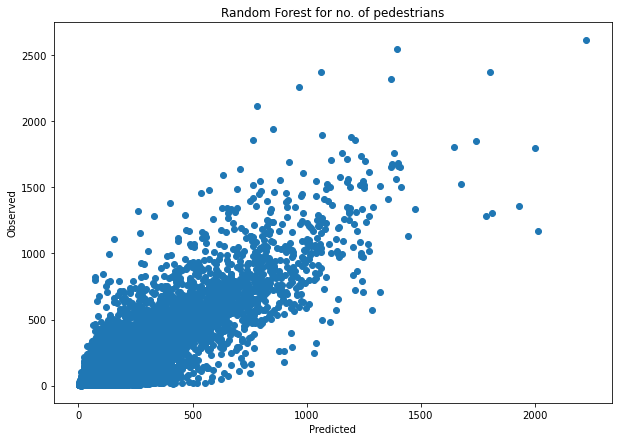

In [41]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("R^2 for Random Forest: %f" % rf.score(x_test, y_test))
    
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_rf, y_test)
plt.title("Random Forest for no. of pedestrians")
plt.xlabel("Predicted")
plt.ylabel("Observed");

In [42]:
# Binning Counts

print('min:',themerge['Hourly_Counts'].min())
print('max:',themerge['Hourly_Counts'].max())

binned = themerge.copy()
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

min_value_score = binned['Hourly_Counts'].min()
max_value_score = binned['Hourly_Counts'].max()
bins_score = np.linspace(min_value_score,max_value_score,28)
binned['counts_binned'] = pd.cut(binned['Hourly_Counts'], bins = bins_score, labels = labels, include_lowest = True)

min: 0.0
max: 2716.1428571428573


In [43]:
# Preparation for ML binned

# Get dummies
model = binned.drop(columns = ['datetime', 'Hourly_Counts'])

# Split the data into train/test set
from sklearn.model_selection import train_test_split

y = model['counts_binned']
x = model[:]
del x['counts_binned']

rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = rs)

#standardize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

R^2 for Logistic Regression: 0.488391


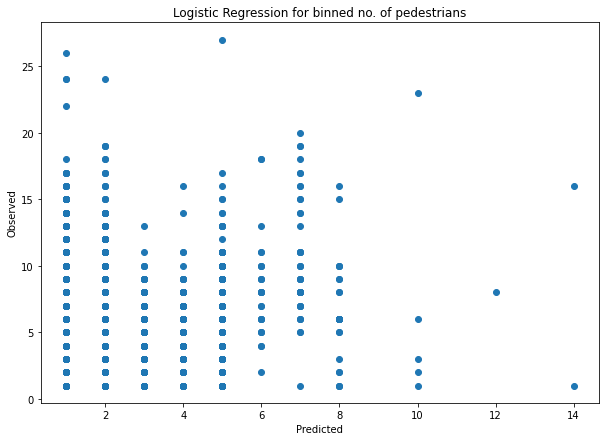

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000)
lr.fit(x_train, y_train)

y_pred_lr = lr.predict(x_test)

print("R^2 for Logistic Regression: %f" % lr.score(x_test, y_test))

plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_lr, y_test)
plt.title("Logistic Regression for binned no. of pedestrians")
plt.xlabel("Predicted")
plt.ylabel("Observed");

R^2 for Random Forest: 0.725685


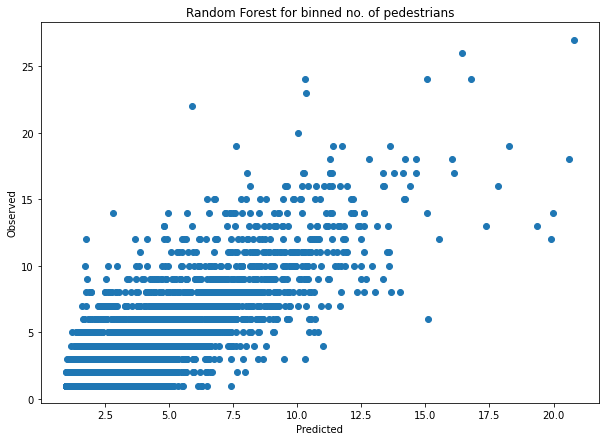

In [45]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("R^2 for Random Forest: %f" % rf.score(x_test, y_test))
    
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_rf, y_test)
plt.title("Random Forest for binned no. of pedestrians")
plt.xlabel("Predicted")
plt.ylabel("Observed");

### ii. Predicting the concentration of particles in the air

Moving on, we would like to predict the quality of air based on given parameters. Wince we didn't succeed with linear regression before, we are only trying with random forest in this case. Quality of air predictions could be useful for weather reports especially for people who have respiratory problems. People could also check these results and compare them to how they are feeling on a given day, to learn more about their health.

<u>**Random Forest:**</u> Resulting in an error of 38.75%, this is not very reliable, so let's see if binning helps.

<u>**Random Forest with binning:**</u> As we have received 37.07%, we can conclude that binning does not help in this case either.

Neither of the two were very reliable, so this technology is still to be improved.

In [46]:
# Preparation for ML par size

# Get dummies
model_psize10 = themerge.drop(columns = ['psize25', 'Year', 'datetime'])
model_psize10 = pd.get_dummies(model_psize10, columns = ['cluster'], drop_first = False)



# Split the data into train/test set
from sklearn.model_selection import train_test_split

y = model_psize10['psize10']
x = model_psize10[:]
del x['psize10']

rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = rs)

#standardize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

R^2 for Random Forest: 0.369648


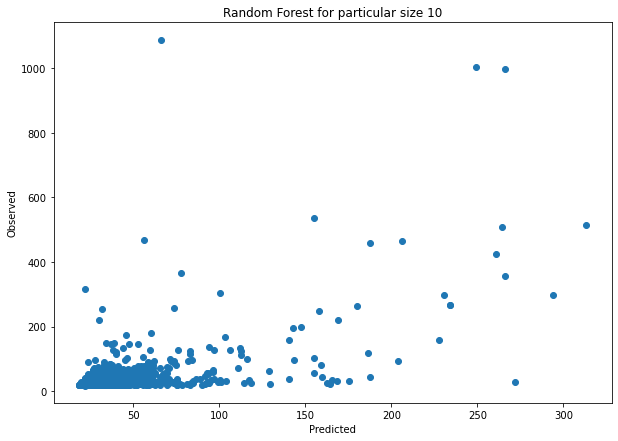

In [47]:
# Random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("R^2 for Random Forest: %f" % rf.score(x_test, y_test))
    
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_rf, y_test)
plt.title("Random Forest for particular size 10")
plt.xlabel("Predicted")
plt.ylabel("Observed");

In [48]:
#Binning

print('min:',themerge['psize10'].min())
print('max:',themerge['psize10'].max())

binned_psize10 = themerge.copy()
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

min_value_score = binned_psize10['psize10'].min()
max_value_score = binned_psize10['psize10'].max()
bins_score = np.linspace(min_value_score,max_value_score,11)
binned['psize10_binned'] = pd.cut(binned['psize10'], bins = bins_score, labels = labels, include_lowest = True)

min: 0.0
max: 1089.34


In [49]:
# Preparation for ML par size

# Get dummies
model_psize10_bin = themerge.drop(columns = ['psize25', 'Year', 'datetime'])
model_psize10_bin = pd.get_dummies(model_psize10_bin, columns = ['cluster'], drop_first = False)

# Split the data into train/test set
from sklearn.model_selection import train_test_split

y = model_psize10['psize10']
x = model_psize10[:]
del x['psize10']

rs = 42
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = rs)

#standardize
x_train = (x_train-x_train.mean())/x_train.std()
x_test = (x_test-x_test.mean())/x_test.std()

R^2 for Random Forest: 0.386211


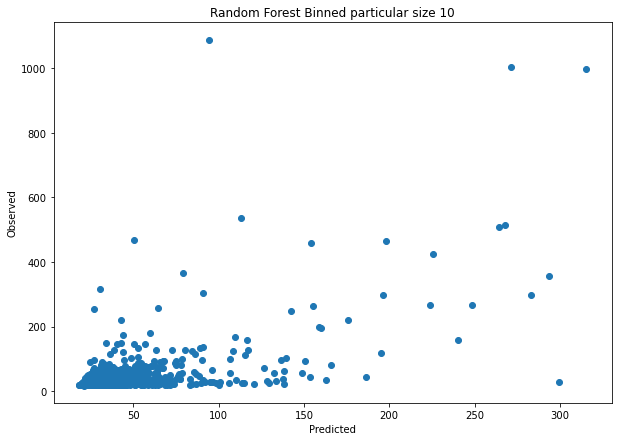

In [50]:
# Random forest
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("R^2 for Random Forest: %f" % rf.score(x_test, y_test))
    
plt.rcParams['figure.figsize'] = [10, 7]
plt.scatter(y_pred_rf, y_test)
plt.title("Random Forest Binned particular size 10")
plt.xlabel("Predicted")
plt.ylabel("Observed");

# 4. Genre

* Which genre of data story did you use?

It is important to mention that though our aricle follows a logical order, a huge part of our project had an experimental aspect to it, including exploring our options regarding both the dataset and the different ways to process and visualize its data. However, it is more than possible that there are still different approaches and explorable aspects to our project, therefore we wanted to invite the reader beside following our way of thinking to be able to create his/her own conclusions by allowing them to participate with our interactive maps and bokeh plots. Based on these two conclusions, we chose magazine style with interactive maps.

* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

Our website is a Continuous Visual Platform with the slidebar simply indicating where are we in the article, thus also utilizing the tool of Progress Bar / Timebar. Regarding narrative visualizations, it is a mixture of author- and reader-driven approach based on the conclusions above, and since it is a website, there was no need for Transition Guidance. Regarding highlighting, Closeups and Zooming are archived via our interactive maps.

* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

Since our dataset is a mixture of author- and reader-driven approach, regarding ordering, our website is Linear in a sense, but one can read it with a Random Acess approach. From the Inreractivity point of view, our maps and bokeh plots utilize Hover Highlighting / Details and Filter / Selection / Search. And finally, as Massaging tools, we used Captions / Headlines, Inroductory Text, Annotations and Summary / Synthesis. However we tried to author- and reader-driven approach, since "messaging might clarify visual elements but produce clutter" and "Interactivity might engage the user but detract from the author’sintended message.

# 5. Visualizations [2]

We chose visualizations based on what explains our message the best.

- The first one was the map. Now this is pretty self explanatory, to display locations the best choice is using a map. We chose folium, because that is something we were familiar with. The animated heatmap displays the how many pedestrians were recorded by a certain sensor each month, starting January, 2019. After that a static map displays the locations of sensor (both climate and pedestrian), along with the clusters we have determined for them. The colors are chosen to achieve better aesthetics and to make it easier to identify which sensor belong together with which other sensors, and to be able to tell a difference between a pedestrian and a microclimate sensor. Upon clicking a marker, one can see the name of a location.

- These are followed by barplots, displaying the numbers of steps in relation with the locations. We chose these because it is easy to tell the difference between a crowded and an empty area, and you can immediately see the proportions between two areas. These are pretty much the default in terms of visualising two dimensional data, where you would like to focus on what value is connected to what other value.

- As we continue our journey, we reach the boxplots. Boxplots are wonderful, because they contain an enormous amount of data. You can immediately see the distribution of the data, and can flood the diagram with other details as well. In our case, we are displaying the **wind**, the **temperature** and the **relative humidity** over a one year period. We chose the bokeh library, because of its wonderful interactive possibilities. To achieve a cleaner diagram, you can see the details upon hovering.

- A linechart is used to display the number of pedestrians over a yearly period. We have used resampling, to decrease the error when taking a look at the weekly amounts. This could also be displayed with a barplot, but since we are displaying both monthly and weekly amounts, it is easier the compare the two on a linechart.

- A correlation matrix as its name suggests is a matrix. The different colors represent different amounts of correlation, for which you can find a guide on the side of the plot. A correlation matrix is pretty much a standard to visualize such data. One can also see details upon hovering with this one as well.

- The observations and predictions are displayed on scatterplots. This beautiful two dimensional plot can display what we expected and we received for one sample at the same time. We know that seeing a chart leading in one direction is what we are looking for, and we can compare the results we receive to that.

# 6. Discussion. Think critically about your creation

# Assessment

Overall we can say that the project was a great success. We have learned a lot both in technological terms and in ways of thinking like an engineer. We can say our choice of data was good, and we have achieved our goals.

# Improvements

If we got a second shot at the project, we would try to optimize our data processing, to require less resources. We are confident that we chose a good solution for this, however in data science you can always shoot higher, because new methods are invented every single day.

Since we were unsuccesful in predicting the quality of air, we came to the conclusion that is is based on factors outside these dataset, such as the number of cars, act of God, and others not recorded by the microclimate sensors.

We believe that if a dataset existed on the number of cars and for example traffic lights, we would have much better predictions and we would have been successful with those as well.

# 7. Contributions. Who did what?

- ST115: Choosing dataset, Preprocessing, visualization, Data Analysis, Evaluating findings, Machine learning, Text editing
- ST195: Choosing dataset, Preprocessing, visualization, Data Analysis, Evaluating findings, Text editing
- ST0  : Choosing dataset, Creating video, Data Analysis, Evaluating findings, Website hosting, Text editing

# 8. References

[1]
ped:<br>
https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Sensor-Locations/h57g-5234<br>
https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp?src=featured_banner<br>
micro:<br>
https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Locations/irqv-hjr4<br>
https://data.melbourne.vic.gov.au/Environment/Microclimate-Sensor-Readings/u4vh-84j8?src=featured_banner<br>
[2] SEGEL, Edward; HEER, Jeffrey. Narrative visualization: Telling stories with data. IEEE transactions on visualization and computer graphics, 2010, 16.6: 1139-1148.

# Handing in the assignment: Simply upload the link to your website to peergrade.